# Metody Obliczeniowe w Nauce i Technice Laboratorium 13
## Minimalizacja funkcji
### Błażej Kustra

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from random import random, randint, sample
from scipy.optimize import dual_annealing

# numpy 1.18.5
# matplotlib 3.2.1
# networkx 2.4
# scipy 1.4.1

### 1. Problem komiwojażera

Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.

### generatory punktów

In [2]:
def random_nodes(n):
    return [(random(), random()) for i in range(n)]

def random_nodes_groups(n, groups):
    return [(randint(1, groups) + random() / groups, 
             randint(1, groups) + random() / groups) for i in range(n)]

def random_nodes_normal_groups(n, mus, sigmas):
    nodes = []
    for mu, sigma in zip(mus, sigmas):
        nodes += [(np.random.normal(mu, sigma), np.random.normal(mu, sigma)) for i in range(n)]
    return nodes

### funkcja do minimalizacji

In [7]:
def pairs(array):
    path = list(zip(array, array[1:]))
    path.append((array[-1], array[0]))
    return path

def get_distance(a, b):
    ax, ay = points[a]
    bx, by = points[b]
    return math.sqrt((ax-bx)**2+(ay-by)**2)

def get_cost(path):
    return sum(map(lambda two: get_distance(*two), pairs(path)))

def function(x, *args):
    sorted_indexes = sorted(range(len(x)), key=lambda i: x[i])
    return get_cost(sorted_indexes)

### rysowanie grafu

In [4]:
def draw_path(x, plot, title):
    plot.set_title(title, fontsize=8)
    plot.axis('off')
    
    sorted_indexes = sorted(range(len(x)), key=lambda i: x[i])
    path = pairs(sorted_indexes)
    
    G = nx.Graph()
    for i, edge in enumerate(path):
        G.add_edge(*edge, order=i)
    
    pos = {x: list(points[y]) for (x, y) in path}
    
    nx.draw_networkx_nodes(G, pos, node_size=3, node_color='black')
    nx.draw_networkx_edges(G, pos, edge_color='purple')

### funkcja uruchamiająca

In [5]:
def run(nodes=random_nodes(10), n=10, mode=None):
    global points
    points = nodes
    
    values = dual_annealing(function, bounds=list(zip([0] * n, [n] * n)), args=(n, mode))
    
    fig = plt.figure(figsize=(7, 6), dpi=200)
    fig.tight_layout()

    before_path_length = str(round(get_cost(list(range(n))), 3))
    after_path_length = str(round(function(values.x), 3))
    
    draw_path(list(range(n)), fig.add_subplot(2, 2, 1), title='Przed: (dlugosc=' + before_path_length + ')')
    draw_path(values.x, fig.add_subplot(2, 2, 2), title='Po: (dlugosc=' + after_path_length + ')')

a) Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).

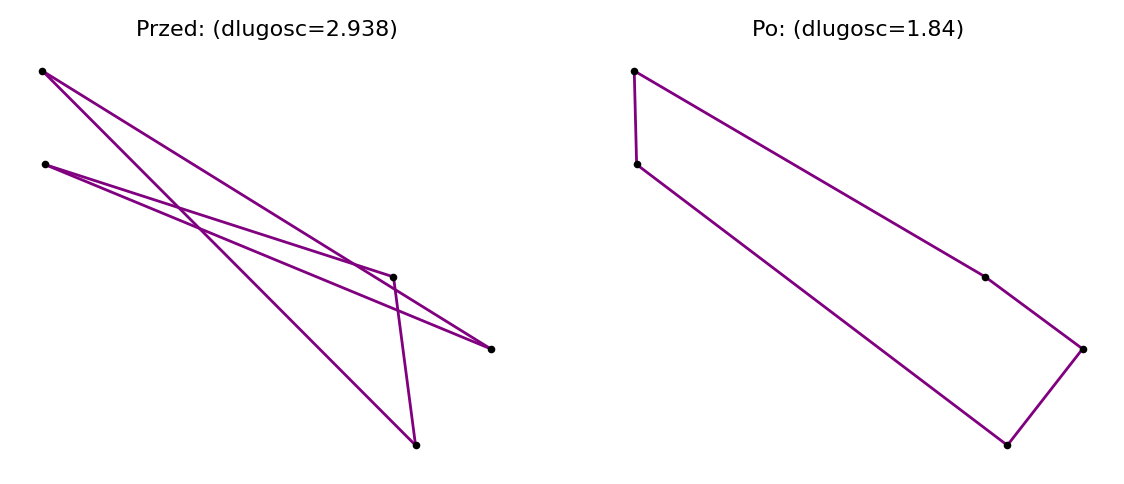

In [8]:
run(n=5) # rozkład jednostajny n=5

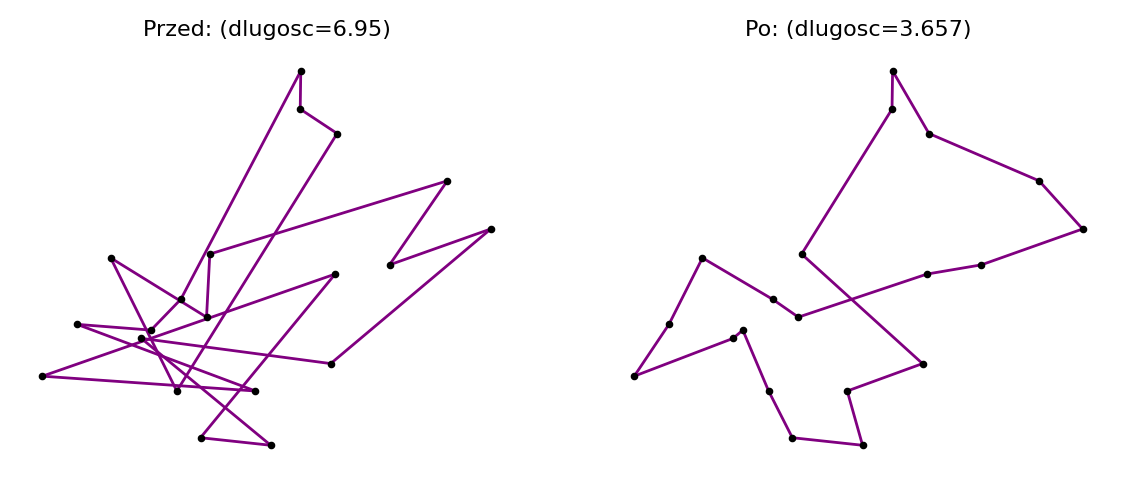

In [9]:
run(random_nodes(20), n=20) # rozkład jednostajny n=20

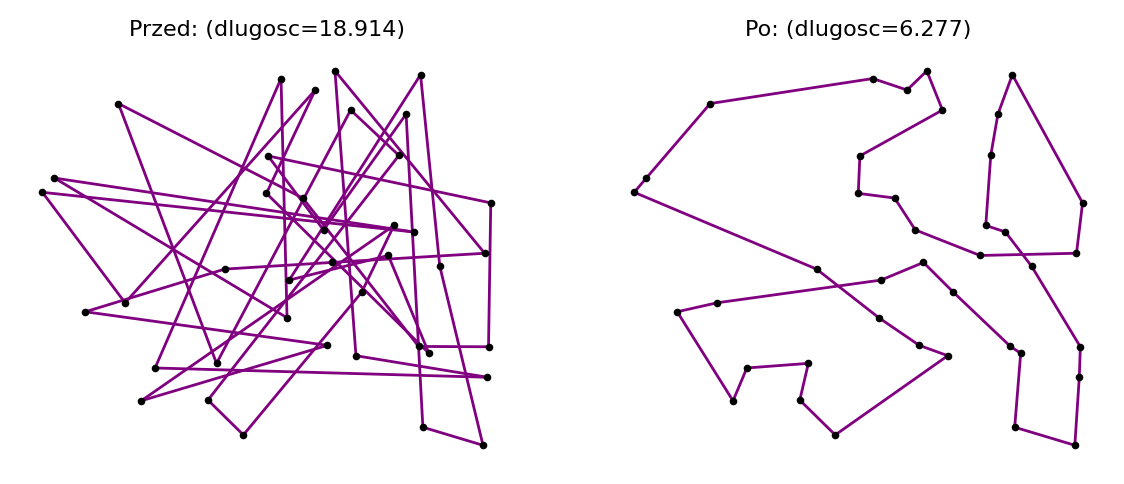

In [10]:
run(random_nodes(40), n=40) # rozkład jednostajny n=40

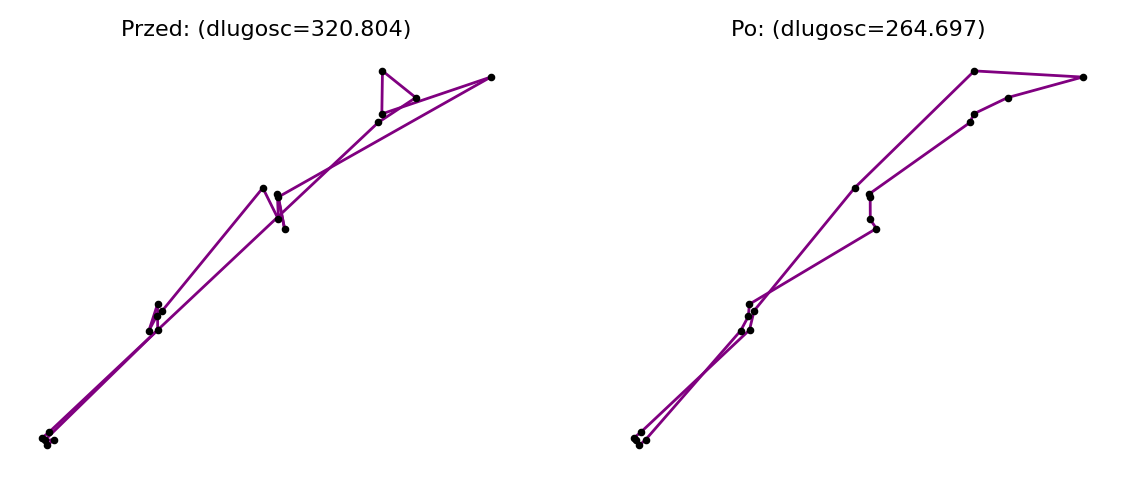

In [11]:
mus = [-25, 0, 25, 50]
sigmas = [1, 2, 3, 8]

run(nodes=random_nodes_normal_groups(5, mus, sigmas), n=20)  # rozkład normalny dla 4 grup n=20

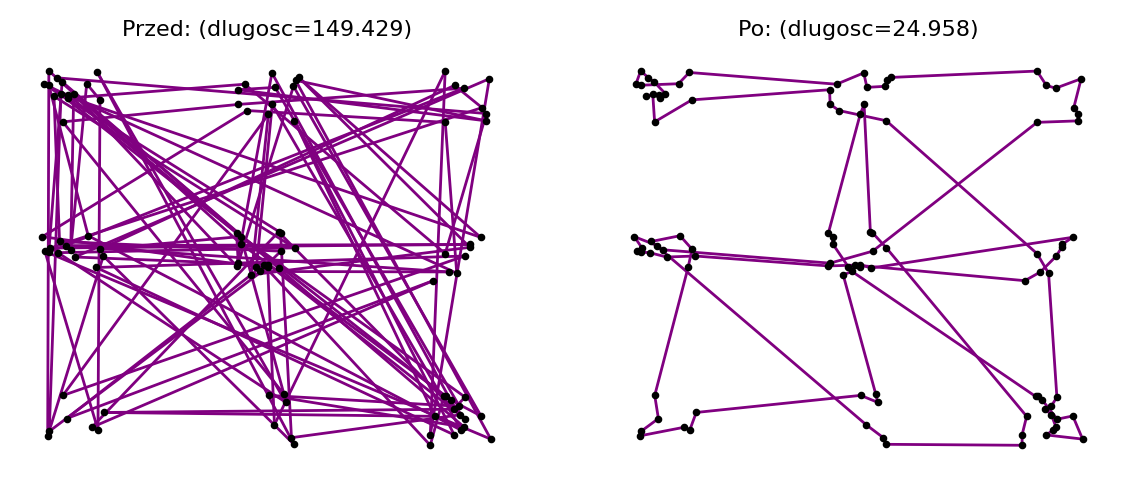

In [12]:
run(nodes=random_nodes_groups(100, 3), n=100) # dziewięć odseparowanych grup n=100

Tak jak można było się spodziewać funkcja $dual\_annealing$ z pakietu $scipy$ działa poprawnie i minimalizuje w naszym przypadku długość ścieżki. 

Dla małych n stwierdzam, że algorytm znalazł minimalną długość ścieżek, jednak dla $n>20$ otrzymane rozwiązanie jest raczej tylko blisko globalnego minimum. Dzieje się tak ze wzgledu na ograniczoną liczbe iteracji oraz na fakt, że algorytm może zwrócić lokalne minimum funkcji (dla dużych n).

Możemy zaobserować ten fakt najlepiej przy grafie z dziewięcioma odseparowanymi grupami. W najlepszym rozwiązaniu każda grupa powinna być połączona jedynie dwoma mostami, a jak widać niektóre grupy mają 3/4 połączenia, przez co możemy mieć pewność, że algorytm nie znalazł minimum globalnego.

b) Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w ścieżce vs. arbitrary swap - zamiana dwóch losowych wierzchołków w ścieżce) oraz początkowej wartości temperatury na zbieżność procesu optymalizacji.

In [13]:
def function(x, *args):
    try:
        n = args[0]
        mode = args[1]

        if mode == 'consecutive':
            i = randint(0, n-2)
            j = i+1
            x[i], x[j] = x[j], x[i]
        elif mode == 'arbitiary':
            i = randint(0, n-1)
            j = randint(0, n-1)
            x[i], x[j] = x[j], x[i]
            
    except IndexError:
        pass
    
    sorted_indexes = sorted(range(len(x)), key=lambda i: x[i])
    return get_cost(sorted_indexes)

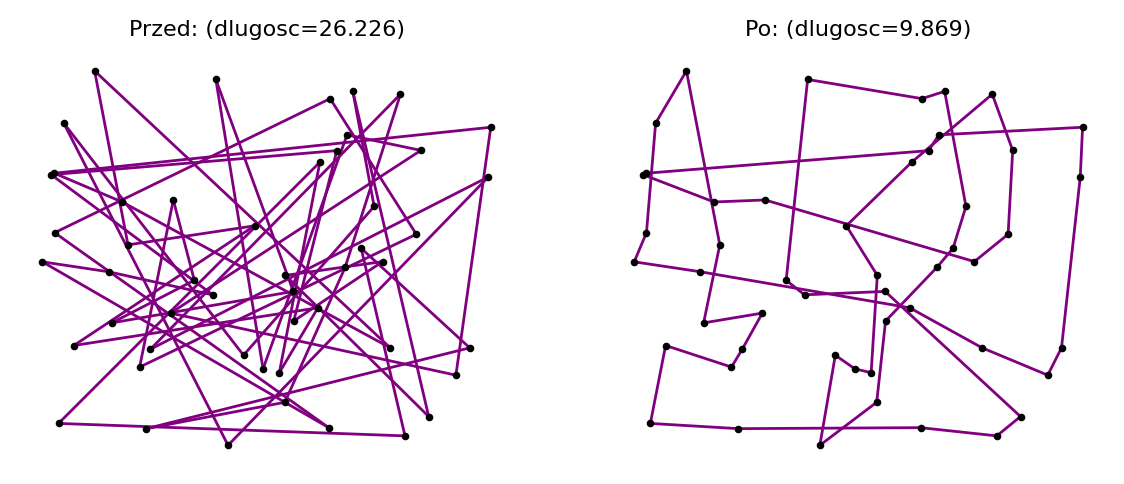

In [14]:
n=50
nodes = random_nodes(n)
run(nodes, n=n, mode="consecutive")

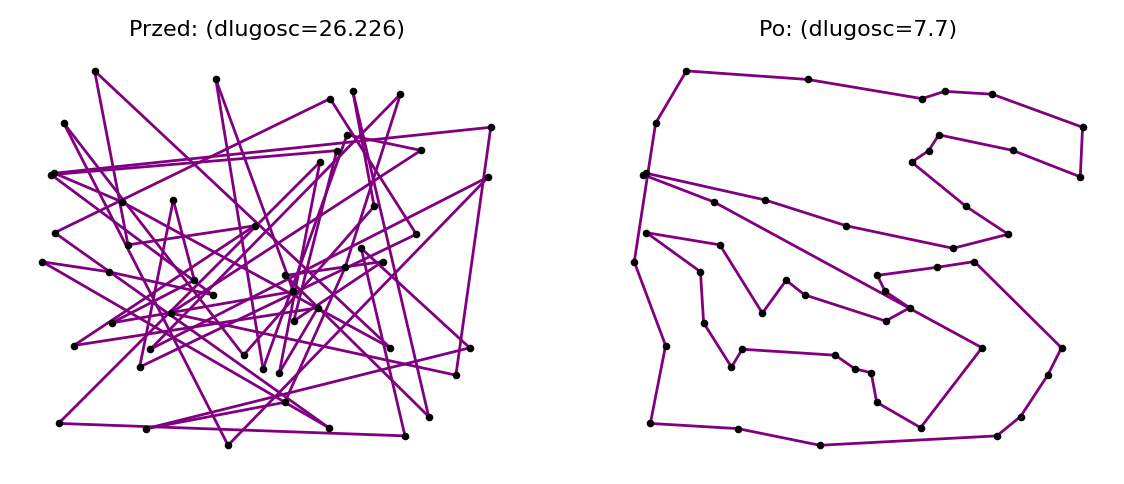

In [15]:
run(nodes, n=n, mode="arbitiary")

Powyżej zaprezentowano działanie algorytmu dla dwóch metod:

 - consecutive swap - zamiana losowego elementu w permutacji z jego następnikiem
 - arbitrary swap - zamiana dwóch losowych elementów permutacji

Sprawdziłem obie metody na zbiorach punktów o rozmiarach $n=10,20,30, ... , 100$. Można zauważyć, że arbitrary swap daje lepsze efekty niż stosowanie consecutive swap. Jest tak ponieważ consecutive swap potrzebuje zwykle większej ilości iteracji aby znaleźć minimalne rozwiązanie funkcji. 

c) Przedstaw wizualizację działania procedury minimalizującej funkcję celu (funkcja przekazana do metody dual annealing może modyfikować zewnątrzny stan)

In [18]:
def function(x, *args):
    global path_lengths
    
    sorted_indexes = sorted(range(len(x)), key=lambda i: x[i])
    path_length = get_cost(sorted_indexes)
    path_lengths.append(path_length)
    
    return path_length

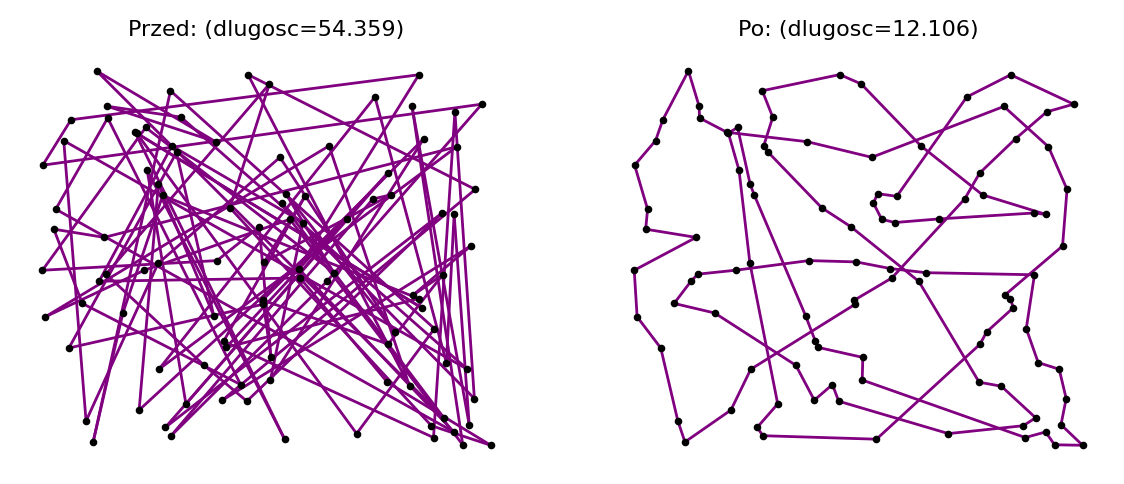

In [19]:
path_lengths = []

run(random_nodes(100), n=100)

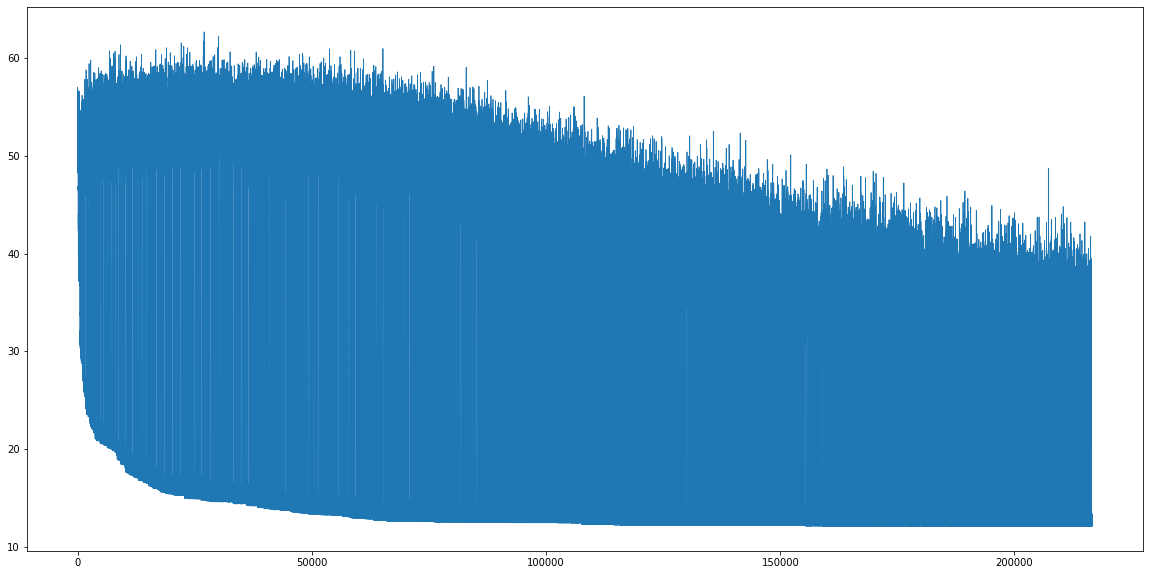

In [20]:
plt.figure(figsize=(20,10))
plt.plot(path_lengths, linewidth=0.8)
plt.show()

Algorytm stosunkowo szybko znajduje niskie wartości, jednak aby znaleźć najkrótszą długość cyklu dla dużych $n$ potrzeba ogromej ilości iteracji. Dzięki zastosowanemu algorytmowi jesteśmy w stanie zminimalizować długość cyklu jednak nie zawsze otrzymamy najkrótszą ścieżkę.

Widoczne na wykresie piki wizualizują wychodzenie z lokalnych minimów. 

### Wnioski:
 - Rodzaj algorytmu heurystycznego -> metoda znajdowania rozwiązań, dla której nie ma gwarancji znalezienia rozwiązania optymalnego, a często nawet prawidłowego. Rozwiązań tych używa się np. wtedy, gdy pełny algorytm jest z przyczyn technicznych zbyt kosztowny lub gdy jest nieznany
 - Symulowane wyżarzanie jest często używane w praktyce szukania minimów globalnych funkcji, np. przy rozwiązywaniu sudoku. 
 - Algorytm jest stosunkowo łatwy do zaimpelmentowania.
 - Dla prostych problemów z niewielką ilością lokalnych minimów metoda wyżarzania jest przesadą, w takich sytuacjach lepiej użyć metody gradientu prostego